In [1]:
! pip install nltk

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize 
import string
import re
from nltk.corpus import stopwords
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [3]:
from google.colab import files
uploaded = files.upload()

In [4]:
df = pd.read_csv('cleaned_dataset.csv')
df.head()

,post,label
0,simply copy and paste the following text into ...,0
1,in order to help increase the booklets downloa...,0
2,as of march 13th 2014 the booklet had been dow...,0
3,click below for a free download of a colorfull...,1
4,click on the download 7 42 mb green banner link,0


In [5]:
df.shape

(45600, 2)

In [6]:
df.dropna(inplace=True)

In [7]:
df.shape

(45599, 2)

In [8]:
# df.label = df.label.astype(int)

In [9]:
df.head()

,post,label
0,simply copy and paste the following text into ...,0
1,in order to help increase the booklets downloa...,0
2,as of march 13th 2014 the booklet had been dow...,0
3,click below for a free download of a colorfull...,1
4,click on the download 7 42 mb green banner link,0


## Pre-processing text data

- Most of the text data are cleaned by following below steps:
    1. Lammetization - Tranforming any form of a word to its root word
    2. Tokenization - Converting a sentence into list of words
    3. Remove punctuations
    4. Remove stopwords

In [10]:
nltk.download('punkt')
def tokenization(text):
  return word_tokenize(text.lower())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
def remove_punct_digits(text):
    text = [re.sub(r'[^a-zA-z\s]', '', word) for word in text]
    text = [word for word in text if len(word)>0] # delete empty words
    return text

In [12]:
nltk.download('stopwords')
def remove_stopwords(text):
    stopword = stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
nlp = spacy.load('en')
def lemmatizer(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [14]:
df['post_clean'] = df['post'].apply(lambda x: lemmatizer(x))

In [15]:
df['post_clean'] = df['post_clean'].apply(lambda x: tokenization(x))

In [16]:
df['post_clean'] = df['post_clean'].apply(lambda x: remove_punct_digits(x))

In [17]:
df['post_clean'] = df['post_clean'].apply(lambda x: remove_stopwords(x))
df.head()

,post,label,post_clean
0,simply copy and paste the following text into ...,0,"[simply, copy, paste, follow, text, youtube, v..."
1,in order to help increase the booklets downloa...,0,"[order, help, increase, booklet, download, wou..."
2,as of march 13th 2014 the booklet had been dow...,0,"[march, th, booklet, download, time, counting]"
3,click below for a free download of a colorfull...,1,"[click, free, download, colorfully, illustrate..."
4,click on the download 7 42 mb green banner link,0,"[click, download, mb, green, banner, link]"


## Exploratory Data Analysis

### Posts length 

Text(0.5, 0, 'post length by word')

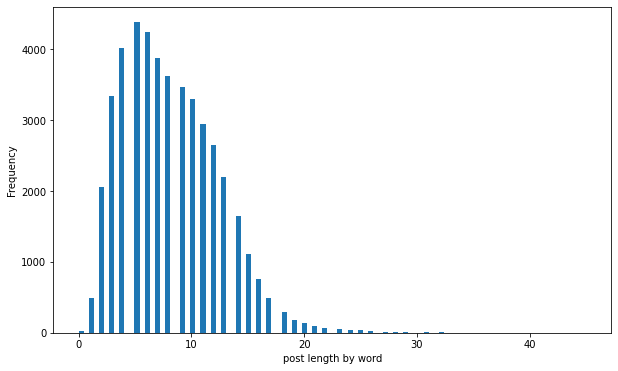

In [18]:
df['post_length'] = df['post_clean'].apply(lambda x: len(x))

plt.figure(figsize=(10, 6))
df['post_length'].plot(
    kind='hist',
    bins=100);
plt.xlabel('post length by word')

In [19]:
df['post_length'].mean()

8.161494769622141

In [20]:
df.drop(columns=['post_length'], axis=1, inplace=True)

In [21]:
df_bully = df[df['label']==1].reset_index().drop(columns='index')
df_nbully = df[df['label']==0].reset_index().drop(columns='index')

In [22]:
cnt1 = Counter()
for i in range (len(df_bully)):
    for word in df_bully.post_clean.loc[[i]].tolist()[0]:
        cnt1[word] += 1
print(cnt1.most_common(50))

[('bitch', 11400), ('``', 4667), ('hoe', 4208), ('get', 3236), ('like', 2876), ('pussy', 2246), ('fuck', 1859), ('go', 1618), ('ass', 1609), ('shit', 1360), ('nigga', 1281), ('u', 1229), ('say', 1114), ('lol', 1025), ('know', 1018), ('girl', 966), ('make', 926), ('sexist', 910), ('_', 882), ('woman', 878), ('amp', 843), ('one', 808), ('man', 806), ('want', 805), ('mkr', 803), ('think', 800), ('see', 796), ('call', 784), ('look', 768), ('would', 750), ('niggas', 739), ('love', 713), ('good', 678), ('white', 674), ('bad', 668), ('hate', 603), ('yo', 602), ('need', 592), ('talk', 586), ('tell', 559), ('come', 547), ('faggot', 544), ('time', 517), ('take', 506), ('fucking', 502), ('people', 497), ('never', 487), ('ya', 483), ('trash', 480), ('back', 479)]


In [23]:
cnt2 = Counter()
for i in range (len(df_nbully)):
    for word in df_nbully.post_clean.loc[[i]].tolist()[0]:
        cnt2[word] += 1
print(cnt2.most_common(50))

[('mkr', 3420), ('``', 1914), ('get', 1554), ('like', 1442), ('go', 1357), ('white', 1233), ('would', 952), ('see', 935), ('people', 933), ('one', 892), ('make', 811), ('say', 778), ('think', 772), ('good', 764), ('look', 743), ('trash', 714), ('know', 700), ('time', 674), ('n', 609), ('want', 597), ('amp', 594), ('kat', 575), ('well', 535), ('year', 517), ('bird', 479), ('take', 470), ('need', 468), ('thing', 457), ('woman', 447), ('day', 436), ('man', 434), ('black', 427), ('youtube', 425), ('back', 416), ('come', 413), ('watch', 403), ('really', 400), ('new', 397), ('find', 393), ('use', 389), ('andre', 386), ('show', 380), ('talk', 376), ('way', 360), ('try', 355), ('even', 355), ('love', 347), ('never', 341), ('give', 337), ('work', 335)]


In [24]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

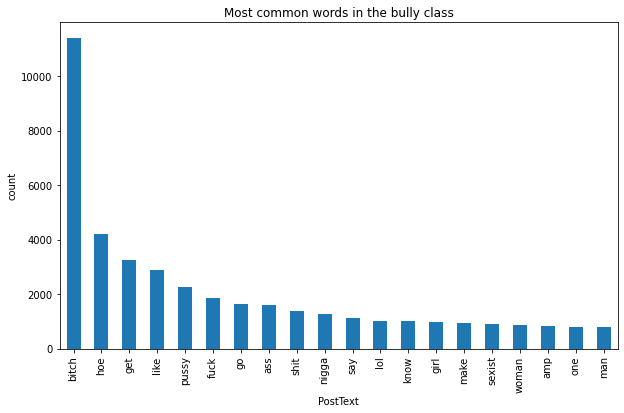

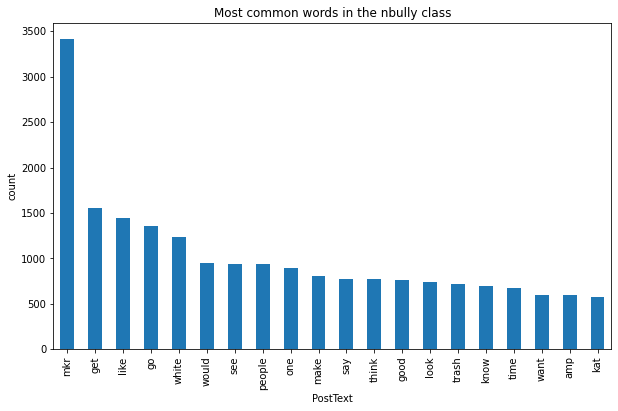

In [25]:
df['post_clean'] = df['post_clean'].apply(lambda x: ' '.join(x))
df_bully['post_clean'] = df_bully['post_clean'].apply(lambda x: ' '.join(x))
df_nbully['post_clean'] = df_nbully['post_clean'].apply(lambda x: ' '.join(x))

common_words_bully = get_top_n_trigram(df_bully['post_clean'], 20)
common_words_nbully = get_top_n_trigram(df_nbully['post_clean'], 20)

plt.figure(figsize=(10, 6))
df_bully_common = pd.DataFrame(common_words_bully, columns = ['PostText' , 'count'])
df_bully_common.groupby('PostText').sum()['count'].sort_values(ascending=False).plot(kind='bar')
plt.title('Most common words in the bully class')
plt.ylabel('count')

plt.figure(figsize=(10, 6))
df_nbully_common = pd.DataFrame(common_words_nbully, columns = ['PostText' , 'count'])
df_nbully_common.groupby('PostText').sum()['count'].sort_values(ascending=False).plot(kind='bar')
plt.title('Most common words in the nbully class')
plt.ylabel('count');

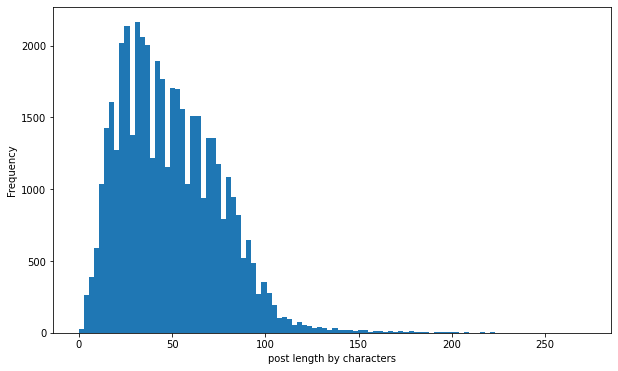

In [26]:
df['post_length'] = df['post_clean'].apply(lambda x: len(x))

plt.figure(figsize=(10, 6))
df['post_length'].plot(
    kind='hist',
    bins=100);
plt.xlabel('post length by characters')
df.drop(columns=['post_length'], axis=1, inplace=True)

### Wordcloud Visualization

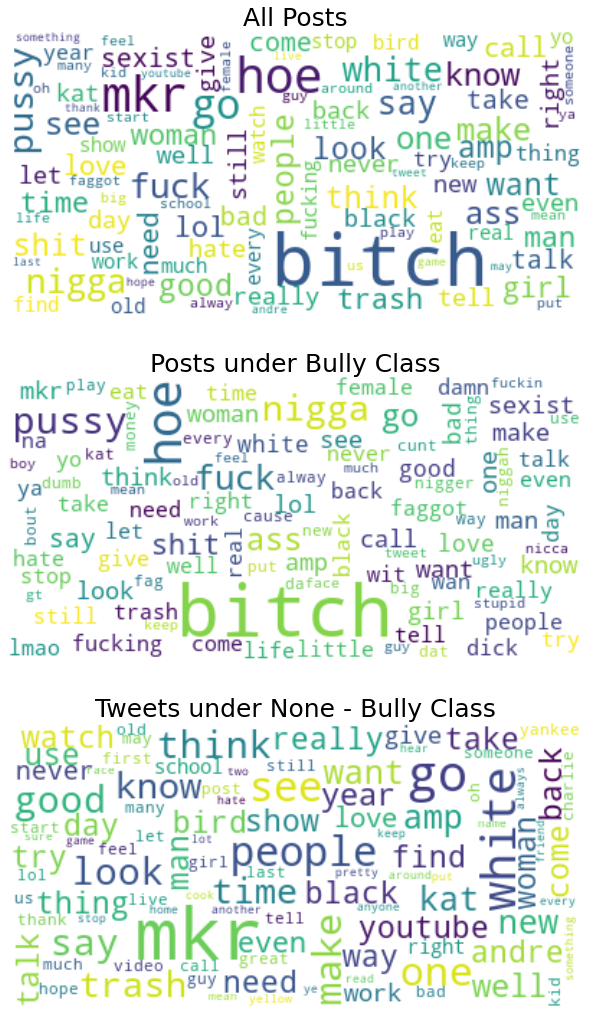

In [27]:
post_all = " ".join(post for post in df.post_clean)
post_bully = " ".join(post for post in df_bully.post_clean)
post_nbully = " ".join(post for post in df_nbully.post_clean)

fig, ax = plt.subplots(3, 1, figsize  = (20,18))
# Create and generate a word cloud image:
wordcloud_all = WordCloud(max_font_size=50, max_words=100, background_color="white", collocations=False).generate(post_all)
wordcloud_bully = WordCloud(max_font_size=50, max_words=100, background_color="white", collocations=False).generate(post_bully)
wordcloud_nbully = WordCloud(max_font_size=50, max_words=100, background_color="white", collocations=False).generate(post_nbully)

# Display the generated image:
ax[0].imshow(wordcloud_all, interpolation='bilinear')
ax[0].set_title('All Posts', fontsize=25)
ax[0].axis('off')
ax[1].imshow(wordcloud_bully, interpolation='bilinear')
ax[1].set_title('Posts under Bully Class',fontsize=25)
ax[1].axis('off')
ax[2].imshow(wordcloud_nbully, interpolation='bilinear')
ax[2].set_title('Tweets under None - Bully Class',fontsize=25)
ax[2].axis('off');

In [28]:
df_bully.head()

,post,label,post_clean
0,click below for a free download of a colorfull...,1,click free download colorfully illustrate page...
1,she may or may not be a jew but she s certainl...,1,may may jew certainly stupid seem think black ...
2,i ve always considered teaching as one of the ...,1,always consider teach one profession would lik...
3,and the sad thing is the white students at tho...,1,sad thing white student school act like
4,their gods often had pale skin and blue eyes b...,1,god often pale skin blue eye suppose literacy ...


In [29]:
df_nbully.head()

,post,label,post_clean
0,simply copy and paste the following text into ...,0,simply copy paste follow text youtube videos d...
1,in order to help increase the booklets downloa...,0,order help increase booklet download would gre...
2,as of march 13th 2014 the booklet had been dow...,0,march th booklet download time counting
3,click on the download 7 42 mb green banner link,0,click download mb green banner link
4,booklet updated on feb 14th 2014,0,booklet update feb th


In [30]:
y = df['label']

In [31]:
X = df['post_clean']

In [32]:
X.head()

0    simply copy paste follow text youtube videos d...
1    order help increase booklet download would gre...
2              march th booklet download time counting
3    click free download colorfully illustrate page...
4                  click download mb green banner link
Name: post_clean, dtype: object

In [33]:
X.shape, y.shape

((45599,), (45599,))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
vectorizer = CountVectorizer(max_features = 500, stop_words = 'english')
X_train_trans = vectorizer.fit_transform(X_train)
X_test_trans = vectorizer.transform(X_test)

In [36]:
X_train_trans.shape, X_test_trans.shape

((36479, 500), (9120, 500))

In [37]:
vectorizer.vocabulary_

{'able': 0,
 'account': 1,
 'act': 2,
 'actually': 3,
 'add': 4,
 'ago': 5,
 'agree': 6,
 'allow': 7,
 'america': 8,
 'american': 9,
 'amp': 10,
 'andre': 11,
 'annie': 12,
 'annoying': 13,
 'answer': 14,
 'anti': 15,
 'anymore': 16,
 'area': 17,
 'asian': 18,
 'ask': 19,
 'ass': 20,
 'attack': 21,
 'away': 22,
 'baby': 23,
 'bad': 24,
 'ball': 25,
 'basic': 26,
 'bc': 27,
 'beat': 28,
 'beautiful': 29,
 'believe': 30,
 'bet': 31,
 'better': 32,
 'big': 33,
 'bird': 34,
 'bit': 35,
 'bitch': 36,
 'bitches': 37,
 'black': 38,
 'block': 39,
 'blonde': 40,
 'blue': 41,
 'body': 42,
 'book': 43,
 'bout': 44,
 'boy': 45,
 'break': 46,
 'bring': 47,
 'bro': 48,
 'brother': 49,
 'brown': 50,
 'brownie': 51,
 'bruh': 52,
 'buy': 53,
 'ca': 54,
 'car': 55,
 'care': 56,
 'cat': 57,
 'catch': 58,
 'cause': 59,
 'change': 60,
 'charlie': 61,
 'cheat': 62,
 'check': 63,
 'chick': 64,
 'child': 65,
 'city': 66,
 'claim': 67,
 'class': 68,
 'clean': 69,
 'close': 70,
 'club': 71,
 'colin': 72,
 'coll

# Naive Bayes Classifier

In [38]:
clf = MultinomialNB()
clf.fit(X_train_trans,y_train)
y_pred = clf.predict(X_test_trans)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      4119
           1       0.84      0.87      0.85      5001

    accuracy                           0.84      9120
   macro avg       0.84      0.83      0.83      9120
weighted avg       0.84      0.84      0.84      9120



In [40]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,3282,837
1,661,4340


# SVM 

In [41]:
clf = SVC()
clf.fit(X_train_trans,y_train)
y_pred = clf.predict(X_test_trans)

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      4119
           1       0.96      0.85      0.90      5001

    accuracy                           0.90      9120
   macro avg       0.90      0.91      0.90      9120
weighted avg       0.91      0.90      0.90      9120



In [43]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,3953,166
1,734,4267


In [44]:
clf = SVC()
tuned_parameters = [{'kernel': ['rbf', 'linear'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100]}]
CV_svc = GridSearchCV(estimator=clf, param_grid=tuned_parameters, cv= 3, verbose=1)
CV_svc.fit(X_train_trans, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 57.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf', 'linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [45]:
CV_svc.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}

In [60]:
CV_svc1=SVC(random_state=42, C=10, gamma= 0.001, kernel='linear')
CV_svc1.fit(X_train_trans, y_train)
y_pred2=CV_svc1.predict(X_test_trans)

In [61]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      4119
           1       0.97      0.84      0.90      5001

    accuracy                           0.90      9120
   macro avg       0.90      0.91      0.90      9120
weighted avg       0.91      0.90      0.90      9120



# RandomForestClassifier:

In [48]:
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train_trans,y_train)
y_pred = clf.predict(X_test_trans)

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4119
           1       0.94      0.87      0.90      5001

    accuracy                           0.89      9120
   macro avg       0.89      0.90      0.89      9120
weighted avg       0.90      0.89      0.89      9120



In [50]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,3820,299
1,668,4333


In [51]:
def get_key(val): 
    for key, value in vectorizer.vocabulary_ .items(): 
         if val == value: 
             return key

In [52]:
words_importances_random_forest = clf.feature_importances_
indices = np.argsort(words_importances_random_forest)[-10:]
for i in indices:
    print(get_key(i))

shit
nigga
ass
fuck
faggot
sexist
mkr
pussy
hoe
bitch


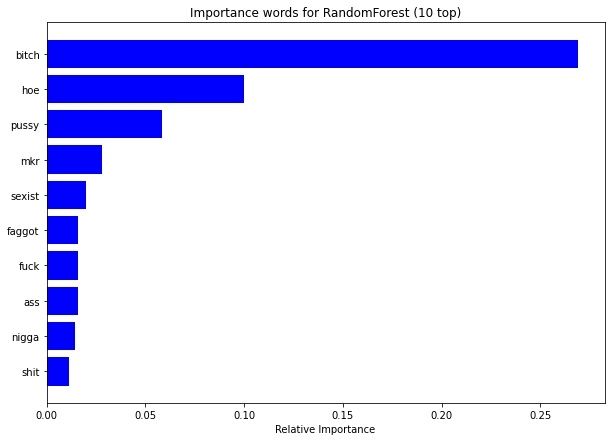

In [53]:
plt.figure(figsize=(10,7))
plt.title('Importance words for RandomForest (10 top)')
plt.barh(range(len(indices)), words_importances_random_forest[indices], color='b', align='center')
plt.yticks(range(len(indices)), [get_key(i) for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [54]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [56]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3, verbose=1)
CV_rfc.fit(X_train_trans, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  5.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [57]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

In [62]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 500, max_depth=8, criterion='entropy')
rfc1.fit(X_train_trans, y_train)
y_pred2=rfc1.predict(X_test_trans)

In [63]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.81      0.97      0.89      4119
           1       0.98      0.81      0.89      5001

    accuracy                           0.89      9120
   macro avg       0.89      0.89      0.89      9120
weighted avg       0.90      0.89      0.89      9120

